In [2]:
%matplotlib inline
%matplotlib widget
import serial
from serial.tools import list_ports

In [3]:
serial.PARITY_NONE

'N'

In [4]:
for port in list_ports.comports():
    print(port)

COM4 - Prolific PL2303GT USB Serial COM Port (COM4)
COM3 - Silicon Labs CP210x USB to UART Bridge (COM3)
COM5 - USB Serial Port (COM5)


In [5]:
PORT="COM4"

ser = serial.Serial(port=PORT, baudrate=9600, bytesize=serial.SEVENBITS,
                    parity=serial.PARITY_ODD, stopbits=serial.STOPBITS_ONE, timeout=1)

for i in range(3):
    print(ser.write(bytes('KRDG?\r\n','utf-8')))
    print(float(ser.readline().decode('utf-8')))

ser.close()

7
304.85
7
304.85
7
304.85


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

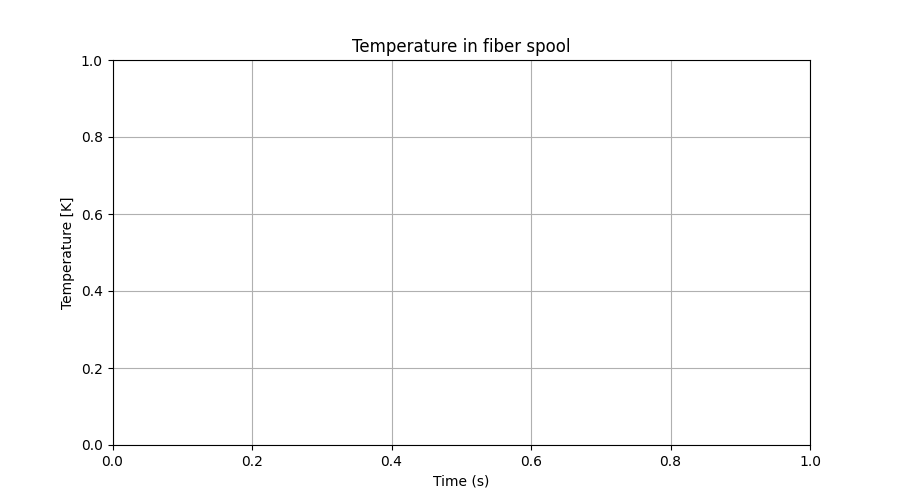

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output, Javascript
import ipywidgets as widgets
import threading
import time
import csv

global ser
ser = serial.Serial(port='COM4', baudrate=9600, bytesize=serial.SEVENBITS,
                    parity=serial.PARITY_ODD, stopbits=serial.STOPBITS_ONE, timeout=1)
global i
i=0

def out_print(message):
    global out, outlines
    out.outputs=()
    outlines=outlines[1:]+[f"{message}\n"]
    for o in outlines:
        out.append_stdout(o)

# Function to generate random numbers and update the plot
def update_plot():
    global running
    global i
    global fig, ax
    while running:
        data.append(getDataPoint())
        times.append(round(time.time()-starttime,3))
        out_print(f"{times[-1]} s, {data[-1]} K")
        ax.clear()  # Clear the previous plot
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Temperature [K]')
        ax.set_title('Temperature in fiber spool')
        ax.grid(True)
        ax.plot(times, data, marker='o', label=f"last temp : {data[-1]}K")
        ax.legend()
        fig.canvas.draw()
        plt.pause(1)  # Pause for 1 second
    ser.close()
    plt.close()

def getDataPoint():
    ser.write(bytes('KRDG?\r\n','utf-8'))
    r = float(ser.readline().decode('utf-8'))
    return r

# Start button click event
def on_start_button_click(b):
    global running, times, data
    times = []
    data = []
    if not(ser.is_open):
        ser.open()
    global starttime
    global startdate
    startdate=time.strftime("%Y-%m-%d %a %Hh%Mmin%Ss",time.localtime())
    out_print(f"START: {startdate}")
    starttime=time.time()
    running = True
    thread = threading.Thread(target=update_plot)
    thread.start()

# Stop button click event
def on_stop_button_click(b):
    on_save_button_click("")
    global running
    running = False
    out_print("STOP")
    
def on_save_button_click(b):
    filename=startdate+f" - fiber T curve - dur {int(times[-1]-times[0])}s"
    with open(filename+".csv",'w') as f:
        writer=csv.writer(f)
        writer.writerows(zip(times,data))
    plt.savefig(filename+".png")
    out_print("data saved in "+filename)
    return

# Create start and stop buttons
start_button = widgets.Button(description='Start')
start_button.on_click(on_start_button_click)

stop_button = widgets.Button(description='Stop & Save')
stop_button.on_click(on_stop_button_click)

save_button = widgets.Button(description='Save')
save_button.on_click(on_save_button_click)

global out, outlines
out = widgets.Output(layout={'border': '1px solid black'})
outlines=5*["\n"]
for o in outlines:
    out.append_stdout(o)

# Display the buttons
display(widgets.HBox([start_button, stop_button, save_button]))

# Initialize the plot
times = []
data = []

global fig, ax
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature [K]')
ax.set_title('Temperature in fiber spool')
ax.grid(True)

display(out)

# Global variable to control the running state of the plot
running = False
